In [1]:
from system import System, DynamicSystem
import torch

In [2]:
system = System(wind_limits=[0.0,0.0])
actor = lambda x: torch.tensor([0.507,0.503])
critic = lambda x: torch.zeros((1))

In [3]:
dynamics = DynamicSystem(system,actor,critic)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field does not have `nn.Parameters` to optimize.


In [4]:
dynamics.calc_total_reward()

-1029.4823547479596

In [5]:
dynamics.actor_loss(dynamics.init_state()), dynamics.critic_loss(dynamics.init_state())

(tensor([11.5500], dtype=torch.float64),
 tensor([133.4025], dtype=torch.float64))

In [6]:
dynamics.visualize_episode(num_workers=4)

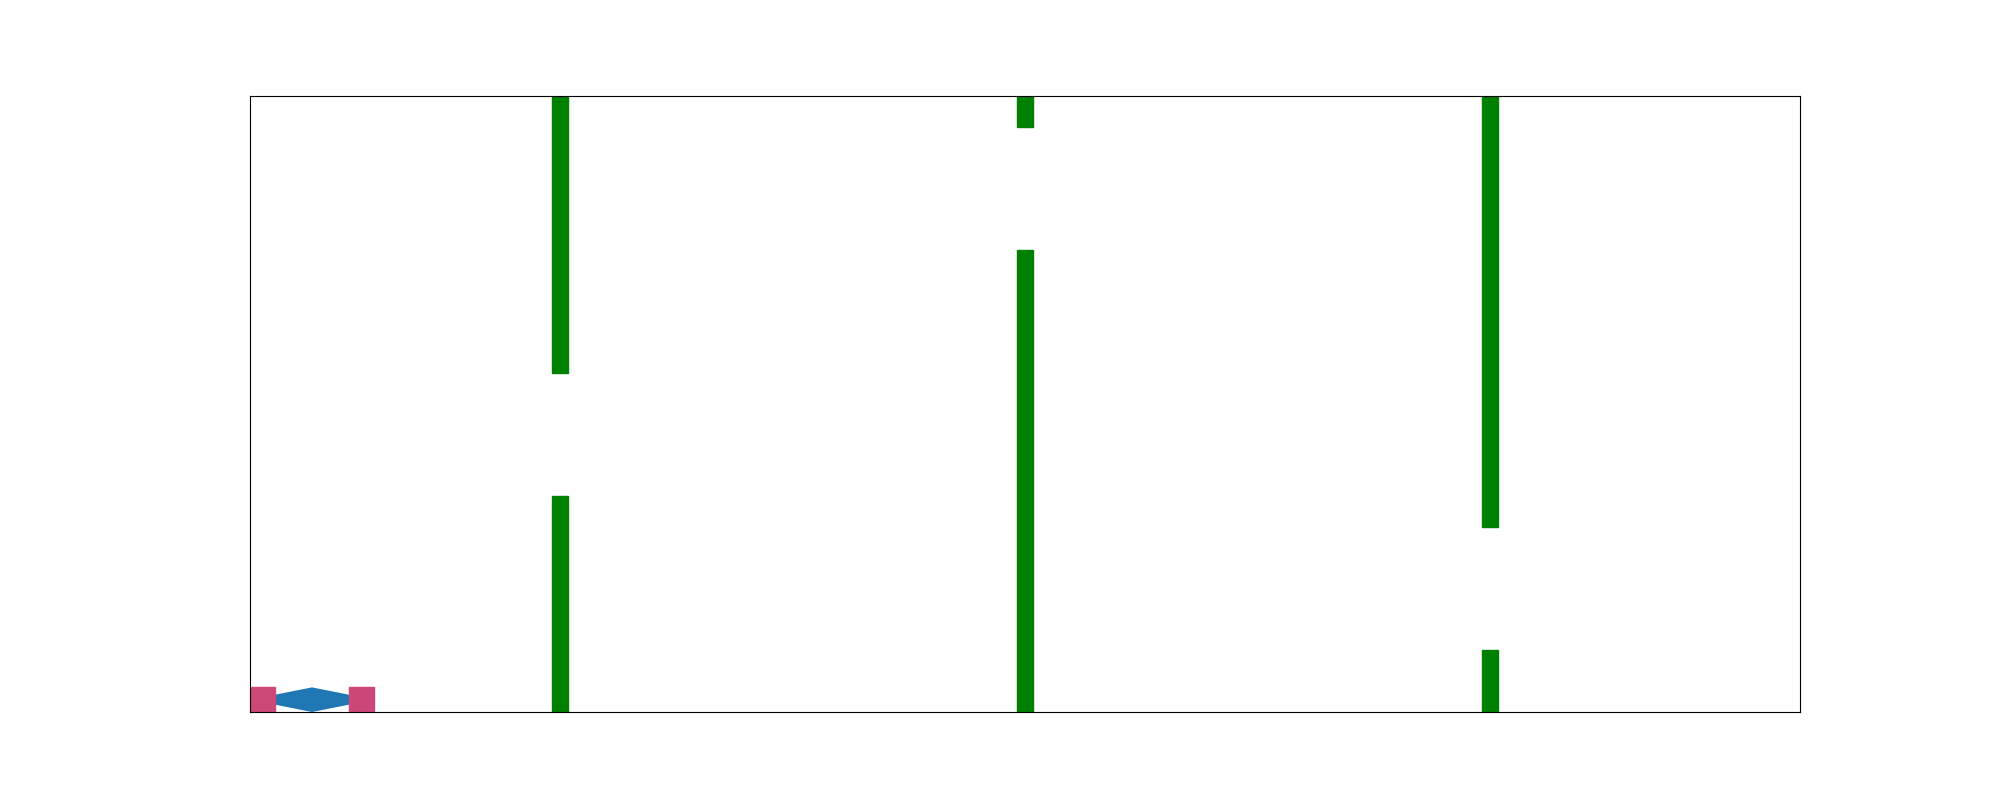

In [7]:
system.visualize_state(dynamics.init_state(),actor(dynamics.get_observation(dynamics.init_state())))

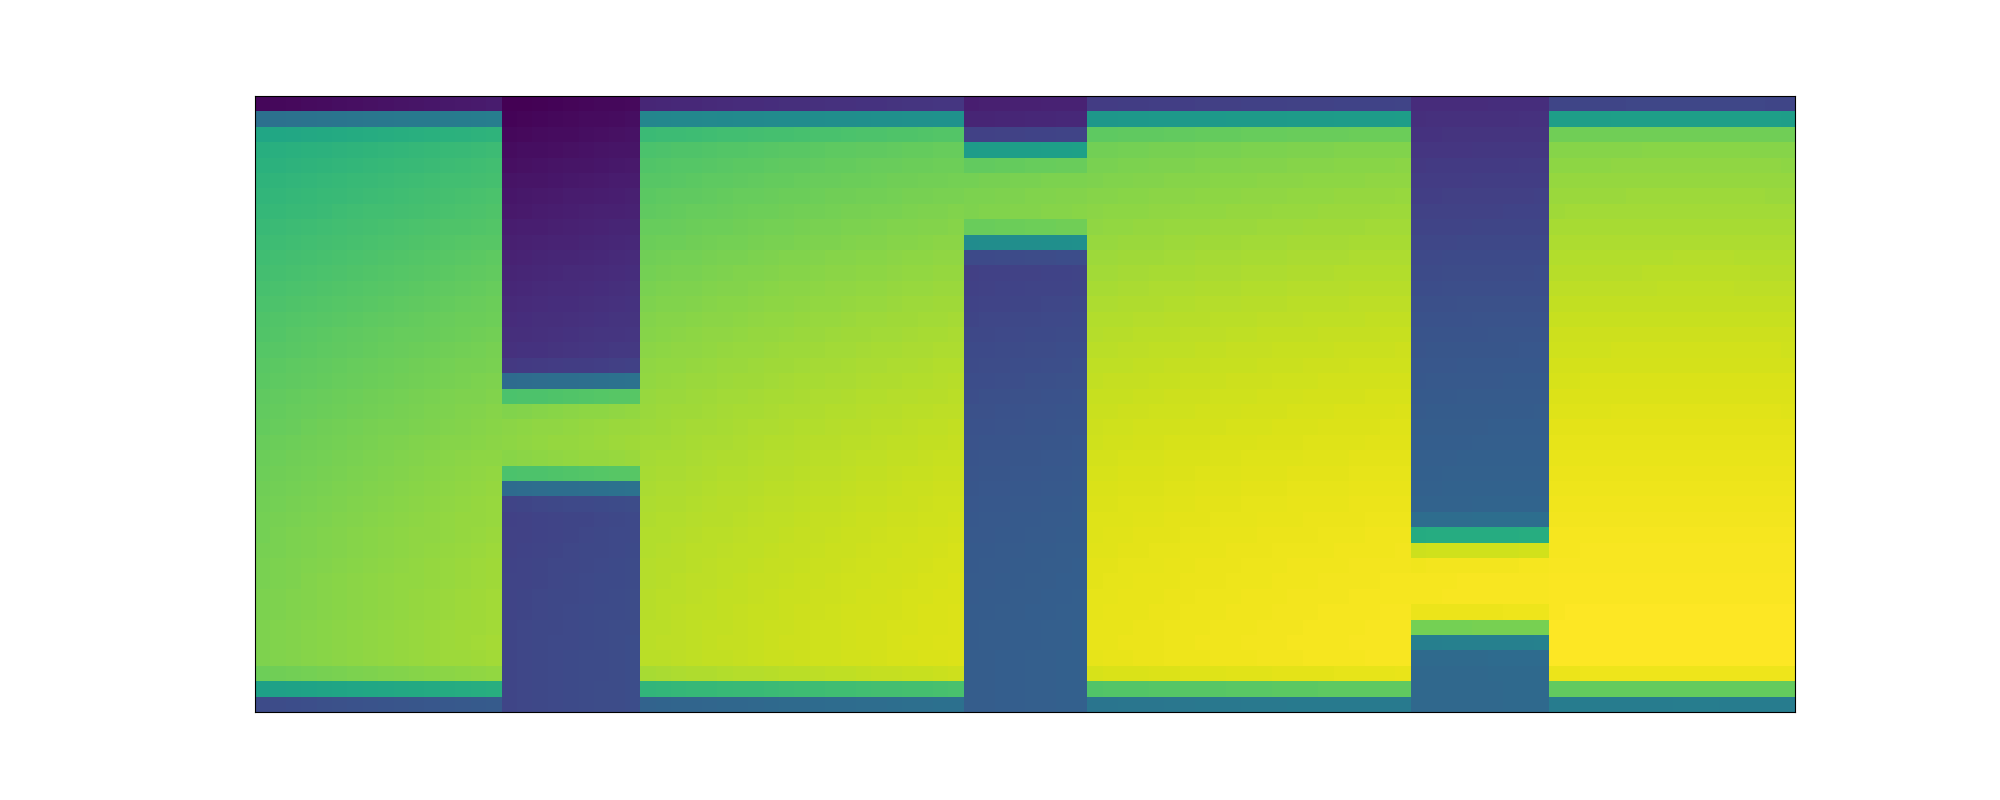

In [8]:
system.visualize_reward(dynamics.init_state(),actor(dynamics.get_observation(dynamics.init_state())))

## Actor-Critic Learning

In [9]:
import torch
import IPython.display as ipd
from functools import partial

from system import System, DynamicSystem
from actor_critic import Actor, Critic, ActorCriticTrainer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
torch.manual_seed(42)

system = System(wind_limits=[0.0,0.0], device=device)
actor = Actor(dim=64, depth=3).double().to(device)
critic = Critic(dim=64, depth=3, scale=1.).double().to(device)

dynamics = DynamicSystem(system,actor,critic, device=device)
actor, critic

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field does not have `nn.Parameters` to optimize.


(Actor(
   (net): Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): LeakyReLU(negative_slope=0.01)
     (4): Linear(in_features=64, out_features=2, bias=True)
     (5): Sigmoid()
   )
 ),
 Critic(
   (net): Sequential(
     (0): Linear(in_features=6, out_features=64, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): LeakyReLU(negative_slope=0.01)
     (4): Linear(in_features=64, out_features=1, bias=True)
     (5): Scale(factor=1.0)
   )
 ))

In [11]:
trainer = ActorCriticTrainer(dynamics=dynamics)
trainer.init_optimizers(
    actor_optimizer=torch.optim.Adam(actor.parameters(), lr=1e-3),
    critic_optimizer=torch.optim.Adam(critic.parameters(), lr=1e-4)
)

In [12]:
def sample_init_state(dynamics, prob=0.5):
    init_state = dynamics.init_state()
    if torch.rand(1) > prob:  # change initial state
        init_state[0] = torch.rand(1, device=dynamics.device) * (system.x_limits[1] / 3 - system.x_limits[0])
        init_state[1] = torch.rand(1, device=dynamics.device) * (system.y_limits[1] - system.y_limits[0])
    return init_state

sample_init_state(dynamics)

tensor([0.5193, 0.2049, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)

In [13]:
training_history = trainer.run(
    iterations=10,
    episodes=32,
    episode_as_batch=True,  # run all episodes at once
    init_state_sampler=partial(sample_init_state, dynamics=dynamics),
    grad_clip_norm=1e4,
    verbose=True
)
training_history

Iteration   1/10: actor_loss=1673.2468, critic_loss=17649.9477, reward=-1574.7272, actor_grad_norm=0.6001, critic_grad_norm=34338.5693
Iteration   2/10: actor_loss=1854.7912, critic_loss=19616.6509, reward=-1717.1590, actor_grad_norm=0.8808, critic_grad_norm=61894.2070
Iteration   3/10: actor_loss=1795.1623, critic_loss=16770.2610, reward=-1605.2632, actor_grad_norm=1.1488, critic_grad_norm=96495.1693
Iteration   4/10: actor_loss=1780.9648, critic_loss=15604.6659, reward=-1550.5525, actor_grad_norm=7.2594, critic_grad_norm=136295.8509
Iteration   5/10: actor_loss=1812.3011, critic_loss=15679.9740, reward=-1558.4309, actor_grad_norm=11.0552, critic_grad_norm=149249.1140
Iteration   6/10: actor_loss=1705.4292, critic_loss=13346.2458, reward=-1434.5158, actor_grad_norm=16.6574, critic_grad_norm=151391.5853
Iteration   7/10: actor_loss=1771.1736, critic_loss=14493.6190, reward=-1493.2412, actor_grad_norm=22.3856, critic_grad_norm=148783.2388
Iteration   8/10: actor_loss=1807.6348, critic_l

defaultdict(list,
            {'actor_loss': [1673.2468113131317,
              1854.7912019571233,
              1795.1622515532533,
              1780.964763002784,
              1812.30114175949,
              1705.4291828023343,
              1771.173608646868,
              1807.634771038454,
              1752.8484131066382,
              1838.2231391296941],
             'critic_loss': [17649.94774039512,
              19616.65094614244,
              16770.260962346594,
              15604.665863367958,
              15679.973982343368,
              13346.245834710333,
              14493.61900129919,
              14972.969725657722,
              13142.074662526484,
              14410.842049961273],
             'reward': [-1574.7272007621007,
              -1717.1589976204596,
              -1605.2631502920876,
              -1550.5525302087333,
              -1558.43088063105,
              -1434.5157579512652,
              -1493.241159555826,
              -1532.4138481

In [ ]:
gif_path = 'episode_ac-n3d64_it10.gif'
dynamics.visualize_episode(save_path=gif_path)
ipd.display(ipd.Image(data=open(gif_path,'rb').read(), format='png'))

In [ ]:
# continue training
training_history = trainer.run(
    iterations=1000,
    episodes=1,
    grad_clip_norm=1e4,
    verbose=True
)